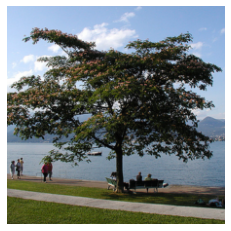

In [5]:
from __future__ import print_function
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
#################### DATA PREPARATION
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

# check if debug job on biwidl machine
if os.environ['USER'] == 'segerm':
    data_dir = "/scratch_net/biwidl215/segerm/ImageNetVal2012"
else:
    data_dir = "/home/marc/Downloads/ImageNetVal2012/"

data = datasets.ImageFolder(data_dir, transform=data_transform)

#print(indices[split - 64:split])
mask_test_indices = [17370, 48766, 5665, 2989, 28735, 45554, 12487, 2814, 7516, 18679, 17954, 961,
                     30928, 1791, 48390, 4393]

mask_test_dataset = Subset(data, mask_test_indices)
mask_test_data_loader = DataLoader(mask_test_dataset, batch_size=16)
mask_test_data = next(iter(mask_test_data_loader))
mask_test_imgs, mask_test_labels = mask_test_data[0][:16], mask_test_data[1][:16]

plt.axis('off')
plt.imshow(mask_test_imgs[1].permute(1, 2, 0))

interactive(children=(Dropdown(description='Model name:', options=('dynamic_vit_teacher', 'dino_small_dist', '…

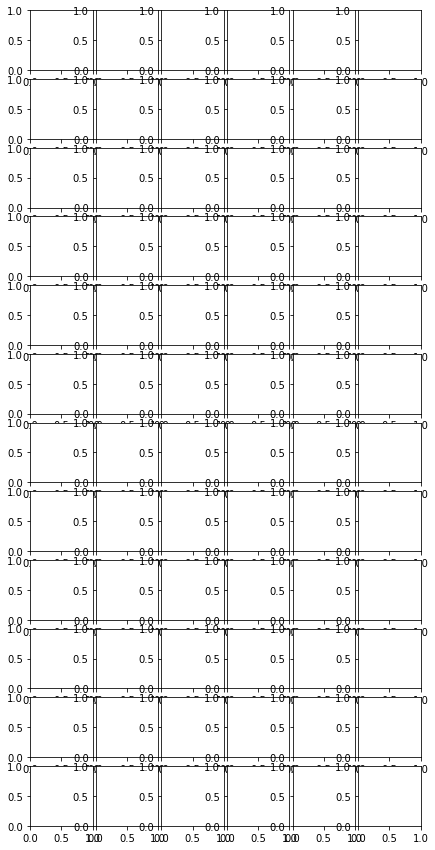

In [17]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import interpolate

model_classifcations = np.load('unpruned_model_classifcations.npy', allow_pickle=True)
model_attn_weights = np.load('unpruned_model_attention_weights.npy', allow_pickle=True)

model_names = list(model_attn_weights[()].keys())
model_classifcations = model_classifcations[()]
model_attn_weights = model_attn_weights[()]

num_images = model_attn_weights[list(model_attn_weights.keys())[0]].shape[1]

@interact(use_shape=True,
          threshold=widgets.IntSlider(min=0, max=100, step=10, value=10, description='Threshold'),
          image_idx=widgets.IntSlider(min=1, max=num_images, step=1, value=1, description='Image'),
          model=widgets.Dropdown(
            options=model_names,
            description='Model name:',
            disabled=False,
        )
)
def interactive_attn_visualization(model, image_idx, threshold, use_shape):

    image = mask_test_imgs[image_idx]

    if 'dino' not in model:
        classifications = model_classifcations[model]
    attn_weights = model_attn_weights[model]
    attn_weights = attn_weights[:, image_idx]
    has_shape_token = True if attn_weights.shape[-1] == 198 else False

    if has_shape_token and use_shape:
        cls_weights, shape_weights, spatial_weights = attn_weights[:, :, 1, 0],\
                                                     attn_weights[:, :, 1, 1],\
                                                     attn_weights[:, :, 1, 2:]
        cls_weights = torch.Tensor(cls_weights)
        shape_weights = torch.Tensor(shape_weights)
        spatial_weights = torch.Tensor(spatial_weights)
    elif attn_weights.shape[-1] == 198:
        cls_weights, shape_weights, spatial_weights = attn_weights[:, :, 0, 0],\
                                                     attn_weights[:, :, 0, 1],\
                                                     attn_weights[:, :, 0, 2:]
        cls_weights = torch.Tensor(cls_weights)
        shape_weights = torch.Tensor(shape_weights)
        spatial_weights = torch.Tensor(spatial_weights)
    else:
        cls_weights, spatial_weights = attn_weights[:, :, 0, 1], attn_weights[:, :, 0, 1:]
        cls_weights = torch.Tensor(cls_weights)
        spatial_weights = torch.Tensor(spatial_weights)

    num_rows = cls_weights.shape[0]
    num_cols = cls_weights.shape[1]

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(7, 15),
                            gridspec_kw={'wspace': 0.05, 'hspace': 0.15})
    
    for row in enumerate(range(num_rows)):
        spatial_weights_sum = torch.sum(spatial_weights, dim=1)
        # attn /= torch.sum(attn, dim=-1, keepdim=True)  # normalize again after excluding CLS weight
        # maximum and minimum attention weight across all the heads of one layer for scaling the colormap
        max_attn_weight, _ = torch.max(spatial_weights, dim=1)
        th_attn = spatial_weights.clone()
        sorted_attn, idx = torch.sort(th_attn, dim=1)
        sorted_attn /= torch.sum(sorted_attn, dim=1, keepdim=True)
        cum_sum = torch.cumsum(sorted_attn, dim=1)
        mask = (cum_sum > threshold).float()
        th_attn.scatter_(dim=1, index=idx, src=mask)
        for col in range(num_cols):
            # specify subplot and turn of axis
            print(row, col)
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            axs[row, col].set_aspect('equal')
            # plot filter channel in grayscale
            # if classifications is not None:
            #     title_str += f'{"Correct" if classifications[(row * num_cols) + col] else "Wrong"}'
            #         axs[row, col].set_title(title_str, fontsize=12)
            if has_shape_token:
                axs[row, col].set_title(f'{cls_weights[col]:.2f} | {shape_weights[col]:.2f} | '
                                        f'{spatial_weights_sum[col]:.3f}', fontsize=7, y=0.93)
            else:
                axs[row, col].set_title(f'{cls_weights[col]:.2f}    |   '
                                        f'{spatial_weights_sum[col]:.3f}', fontsize=7, y=0.93)
            axs[row, col].imshow(image, interpolation='nearest')
            head_attn = np.round(th_attn[col], 4)
            num_patches = head_attn.shape[0]
            patches_per_image_dim = int(np.sqrt(num_patches))
            patch_size = int(image.shape[-2] // np.sqrt(num_patches))
            head_attn = head_attn.reshape(1, 1, patches_per_image_dim, patches_per_image_dim)

            head_attn = interpolate(head_attn, scale_factor=patch_size, mode="nearest")\
                .reshape(image.shape[-2], image.shape[-2])
            heatmap = axs[row, col].imshow(head_attn, cmap='inferno', alpha=0.70)
            # cbar = plt.colorbar(heatmap, ax=axs[row, col])
            # cbar.set_ticks([cbar.vmax])
            # cbar.ax.tick_params(labelsize=7)
            # heatmaps.append(heatmap)

        # pos = axs[row, -1].get_position()
    # cbar_ax = fig.add_axes([0.05, 0.12, 0.9, 0.01])
    # cbar = fig.colorbar(heatmap, cax=cbar_ax, orientation='horizontal')
    # cbar.set_ticks([cbar.vmin, cbar.vmax])
    # cbar.set_ticklabels(['min', 'max'])
    # cbar.ax.set_xlabel('Attention weight magnitude for different heads (left to right) of an encoder layer,\n'
    #                    'starting with the layer nearest to the input at the top and the final layer before\nthe '
    #                    'classification head at the bottom. The number above each image are the\nweight of the CLS '
    #                    'token and the maximum weight among all the other\nspatial tokens for that attention head.', fontdict={'size': 12})
    # cbar.ax.tick_params(labelsize=10)

    # suptitle_str = f'CLS attention evolution through layers\n' \
    #                f'epoch: {epoch_num}, validation accuracy: {args.epoch_acc:.4f}\n' \
    #                f'using {"perturbed top-k" if args.topk_selection else "gumbel softmax"} predictor\n' \
    #                f'Pruning patches before layers [{",".join(str(loc) for loc in args.pruning_locs)}]\n' \
    #                f'with keeping ratios of [{",".join(str(round(ratio, 2)) for ratio in args.keep_ratios)}]'
    # if args.topk_selection:
    #     suptitle_str += f' current sigma: {args.current_sigma:.4f}'
    suptitle_str = 'Thresholding the attention weights of a DINO ViT-S with patch size 16\n and 14x14 patch grid. ' \
                   'The numbers above each image indicate\n' \
                   'the attention weight of the CLS token, the shape token, and the\nsum of all the spatial tokens ' \
                   'in the self attention of the shape token.\n\n'\
                   'The bright regions are obtained by keeping the top 90% of the spatial tokens\nand discarding the ' \
                   'other tokens.\n'\
                   'Each column visualizes the one of the 6 heads used in the MHSA.\n' \
                   'Each row visualizes all the heads of one encoder layer,\nstarting with the input layer at the top.'


    fig.suptitle(suptitle_str, fontsize=13)
    fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.80)
    plt.show()